#1. Data Preprocessing

In [1]:
from tensorflow.keras.utils import get_file

BASE_PATH = 'https://storage.googleapis.com/quickdraw_dataset/full/binary/'
animal_name = ['cat','elephant','giraffe','lion','panda','pig','rabbit','snake']
path = list()
for name in animal_name:
  path.append(get_file(name, BASE_PATH + name + '.bin'))

In [2]:
len(path)

8

In [3]:
import PIL
from PIL import Image
from PIL import ImageDraw
from struct import unpack
from sklearn.model_selection import train_test_split
import tensorflow
import matplotlib.pyplot as plt
import json, glob
import numpy as np

In [4]:
def add_draw(path_list, x, y):
    """
    데이터를 불러오는 역할을 하는 함수입니다.
    """    
    label = 0
    count = 70000
    for path in path_list:
      # 파일을 불러와 스케치를 하나하나 모읍니다.
      # 스케치가 15바이트 헤더로 시작하기 때문이 이런 부분을 전처리하여 줍니다.
      count = 70000
      with open(path, 'rb') as f:
          while True:
              img = PIL.Image.new('L', (32, 32), 'white')
              draw = ImageDraw.Draw(img)
              header = f.read(15)
              if len(header) != 15:
                  break
              
              # 낙서는 x,y 좌표로 구성된 획(stroke) 목록으로 되어 있고, 각 좌표는 분리되어 저장되어 있습니다.
              # 방금 위에서 생성한 ImageDraw 객체의 좌표 목록을 이용하기 위해 zip() 함수를 사용하여 합쳐주도록 합니다.
              strokes, = unpack('H', f.read(2))
              
              for i in range(strokes):
                  n_points, = unpack('H', f.read(2))
                  fmt = str(n_points) + 'B'
                  read_scaled = lambda: (p // 8 for 
                                        p in unpack(fmt, f.read(n_points)))
                  points = [*zip(read_scaled(), read_scaled())]
                  draw.line(points, fill=0, width=2)
              img = tensorflow.keras.preprocessing.image.img_to_array(img)
              x.append(img)
              y.append(label)
              count -= 1
              if count <= 0:
                break
          label += 1
    return x, y

In [5]:
x = []
y = []
x, y = add_draw(path, x, y)

In [6]:
x = np.asarray(x) / 255
y = np.asarray(y)

elephant


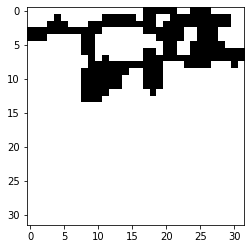

In [7]:
plt.imshow(x[111000][:,:,0], cmap='gray')
print(animal_name[y[111000]])

#2. CNN Modeling

In [8]:
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.85, stratify=y)

snake


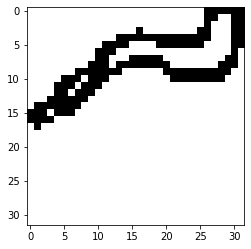

In [17]:
plt.imshow(X_train[191][:,:,0], cmap='gray')
print(animal_name[y_train[191]])

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

model = Sequential()
model.add(Conv2D(16, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(16, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(animal_name), activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
model.fit(X_train, y_train,
          batch_size=128,
          validation_data=(X_test, y_test),
          epochs=100,
          callbacks=[tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/100
3719/3719 [==============================] - 27s 5ms/step - loss: 0.6019 - accuracy: 0.8004 - val_loss: 0.4452 - val_accuracy: 0.8543
Epoch 2/100
3719/3719 [==============================] - 17s 4ms/step - loss: 0.3989 - accuracy: 0.8694 - val_loss: 0.3851 - val_accuracy: 0.8741
Epoch 3/100
3719/3719 [==============================] - 18s 5ms/step - loss: 0.3484 - accuracy: 0.8855 - val_loss: 0.3720 - val_accuracy: 0.8796
Epoch 4/100
3719/3719 [==============================] - 17s 4ms/step - loss: 0.3185 - accuracy: 0.8949 - val_loss: 0.3581 - val_accuracy: 0.8833
Epoch 5/100
3719/3719 [==============================] - 18s 5ms/step - loss: 0.2969 - accuracy: 0.9018 - val_loss: 0.3542 - val_accuracy: 0.8884
Epoch 6/100
3719/3719 [==============================] - 17s 4ms/step - loss: 0.2795 - accuracy: 0.9071 - val_loss: 0.3557 - val_accuracy: 0.8872
Epoch 7/100
3719/3719 [==============================] - 16s 4ms/step - loss: 0.2646 - accuracy: 0.9119 - val_loss: 0.3543 -

In [18]:
save_path = '/content/model.h5'
model.save(save_path)